In [67]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from glob import glob
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 处理文件列不匹配问题

## 1.1 方案一，文件去除法，不具有普适性

In [2]:
files1 = glob("../datas/data/更换批杆watchdata/更换前/*.csv")
files2 = glob("../datas/data/更换批杆watchdata/更换后/*.csv")

In [9]:
def clean_csv(input_path, output_path=None, encoding='utf-8'):
    cleaned_lines = []
    # 读取并清理每一行
    with open(input_path, 'r', encoding=encoding) as f:
        for line in f:
            # 去除行尾换行符和多余逗号（包括连续逗号）
            cleaned_line = line.rstrip('\n')[:-2]
            cleaned_lines.append(cleaned_line)

    # 写入清理后的文件（可选）
    if output_path:
        with open(output_path, 'w', encoding='utf8') as f:
            f.write('\n'.join(cleaned_lines))

In [13]:
for file in files1:
    try:
        _ = clean_csv(file, output_path=os.path.join("../datas/data/更换批杆watchdata/before", os.path.basename(file)), encoding='gbk')
    except:
        _ = clean_csv(file, output_path=os.path.join("../datas/data/更换批杆watchdata/before", os.path.basename(file)), encoding='utf-8')
for file in files2:
    try:
        _ = clean_csv(file, output_path=os.path.join("../datas/data/更换批杆watchdata/after", os.path.basename(file)), encoding='gbk')
    except:
        _ = clean_csv(file, output_path=os.path.join("../datas/data/更换批杆watchdata/after", os.path.basename(file)), encoding='utf-8')

## 1.2 方案二，先读取再重排列

# 2. 合并文件并分析

In [52]:
files1 = glob("../datas/data/更换批杆watchdata/before/*.csv")
files2 = glob("../datas/data/更换批杆watchdata/after/*.csv")

In [63]:
df1 = [pd.read_csv(file, encoding='utf8', on_bad_lines='skip') for file in files1]
df2 = [pd.read_csv(file, encoding='utf8', on_bad_lines='skip') for file in files2]

df_before = pd.concat(df1, ignore_index=True)
df_after = pd.concat(df2, ignore_index=True)

In [54]:
df_before.to_csv("../datas/data/更换批杆watchdata/before.csv", index=False)
df_after.to_csv("../datas/data/更换批杆watchdata/after.csv", index=False)

## 2.1 对比两个文件

In [64]:
df_before['change'] = 0
df_after['change'] = 1
df_use = pd.concat([df_before, df_after], ignore_index=True)
df_use.columns = [x.lower() for x in df_before.columns]

In [ ]:
# 数据预处理函数
def preprocess_data(df):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 将空值替换为NG表示成功
    result_cols = ['4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult']
    for col in result_cols:
        df[col] = df[col].fillna('NG')
    
    # 创建总体成功/成功的标签
    df['overall_result'] = 1  # 默认为成功
    for col in result_cols:
        df.loc[df[col] == 'NG', 'overall_result'] = 0
    
    # 工站信息编码
    le = LabelEncoder()
    df['s2s3installptid_enc'] = le.fit_transform(df['s2s3installptid'])
    df['lock_platformid_enc'] = le.fit_transform(df['lock_platformid'])
    
    return df

# 预处理数据
df_process = preprocess_data(df_use)

In [74]:
print(df_process.columns.tolist())

['time', 'hsgsn', 'spk_sn', 'board_sn', 'mode', '4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult', 's2s3installptid', 's2s3assystation', 's2s3assyplatformid', 'lock_platformid', 'lockscrewstation', 'lockscrewplatformid', 'maxpressspkdata', 'maxpresschgdata', 'bracketmaxpress', 'spk screw 4_half finaltorque', 'spk screw 4_half finalangle', 'spk screw 4 prevailingtorquemax', 'spk screw 4 prevailingtorquemaxangle', 'spk screw 4_half realangle', 'spk screw 4_half torqueat630', 'spk screw 4_half prev torque retest logic', 'kc screw 2_full finaltorque', 'kc screw 2_full finalangle', 'kc screw 2_full prevailingtorquemax', 'kc screw 2_full prevailingtorquemaxangle', 'kc screw 2_full realangle', 'kc screw 2_full torqueat630', 'kc screw 2_full prev torque retest logic', 'kc screw 1_full finaltorque', 'kc screw 1_full finalangle', 'kc screw 1_full prevailingtorquemax', 'kc screw 1_full prevailingtorquemaxangle', 'kc screw 1_full realangle', 'kc screw 1_full torque

In [100]:
df_process

,time,hsgsn,spk_sn,board_sn,mode,4_halfatlasresult,2_fullatlasresult,1_fullatlasresult,4_fullatlasresult,s2s3installptid,...,circleradius3_min,circleradius4_max,circleradius4_min,4_screw_anglemax,2_screw_anglemax,1_screw_anglem,change,overall_result,s2s3installptid_enc,lock_platformid_enc
0,2025-06-17 01:03:09 463,HVWHHK0004E0000X45,DTVHGM1326L0000HE6+760691AGFSP,JS-LA5-HM13-L1-LEAD-H1-LG-37,4-2-1-4,OK,OK,OK,OK,S2-1,...,200.0,700.0,200.0,3.0,3.0,3.0,0,1,0,1
1,2025-06-17 01:06:28 793,HVWHHK0002L0000X45,DTVHGM144100000HE6+713493AGFCP,JS-LA5-HM13-L1-LEAD-H1-LG-06,4-2-1-4,OK,OK,OK,OK,S2-1,...,200.0,700.0,200.0,3.0,3.0,3.0,0,1,0,1
2,2025-06-17 01:20:40 715,HVWHHK0001A0000X45,DTVHGM141YT0000HE6+735943AGFBP,JS-LA5-HM13-L1-LEAD-H1-LG-06,4-2-1-4,OK,OK,OK,OK,S2-1,...,200.0,700.0,200.0,3.0,3.0,3.0,0,1,0,1
3,2025-06-17 01:22:43 961,HVWHHK0000M0000X45,DTVHGM132JV0000HE6+729394AGFAP,JS-LA5-HM13-L1-LEAD-H1-LG-24,4-2-1-4,OK,OK,OK,OK,S2-1,...,200.0,700.0,200.0,3.0,3.0,3.0,0,1,0,1
4,2025-06-17 01:33:48 693,HVWHHK0001B0000X45,DTVHGM142U90000HE6+717243AGFBP,JS-LA5-HM13-L1-LEAD-H1-LG-06,4-2-1-4,OK,OK,OK,OK,S2-1,...,200.0,700.0,200.0,3.0,3.0,3.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,2025-07-10 15:33:41 330,F9W006432900000X7V,CTHHGQ1104H0000HE6+7CBH33AGFDA,JS-LA5-HM13-L1-LEAD-H1-LG-06,NaN,NG,NG,NG,NG,S2-1,...,200.0,590.0,200.0,NaN,NaN,NaN,1,0,0,1
2294,2025-07-10 15:34:23 374,F9W006711450000X7V,CTHHGQ110YH0000HE6+7BNR31AGFDA,JS-LA5-HM13-L1-LEAD-H1-LG-14,NaN,NG,NG,NG,NG,S2-1,...,200.0,590.0,200.0,NaN,NaN,NaN,1,0,0,1
2295,2025-07-10 15:35:01 271,F9W006443780000X7V,CTHHGQ110HU0000HE6+7DVN92AGFDA,JS-LA5-HM13-L1-LEAD-H1-LG-11,NaN,NG,NG,NG,NG,S3-1,...,200.0,590.0,200.0,NaN,NaN,NaN,1,0,2,1
2296,2025-07-10 15:49:43 906,F9W002286420000X7Q,CTHHGQ110YH0000HE6+7BNR31AGFDA,JS-LA5-HM13-L1-LEAD-H1-LG-17,NaN,NG,NG,NG,NG,S3-1,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,2,1


In [77]:
df_process[['time', 'mode', '4_halfatlasresult', '2_fullatlasresult', '1_fullatlasresult', '4_fullatlasresult', 'change', 'overall_result', 's2s3installptid_enc', 'lock_platformid_enc']]

,time,mode,4_halfatlasresult,2_fullatlasresult,1_fullatlasresult,4_fullatlasresult,change,overall_result,s2s3installptid_enc,lock_platformid_enc
0,2025-06-17 01:03:09 463,4-2-1-4,OK,OK,OK,OK,0,1,0,1
1,2025-06-17 01:06:28 793,4-2-1-4,OK,OK,OK,OK,0,1,0,1
2,2025-06-17 01:20:40 715,4-2-1-4,OK,OK,OK,OK,0,1,0,1
3,2025-06-17 01:22:43 961,4-2-1-4,OK,OK,OK,OK,0,1,0,1
4,2025-06-17 01:33:48 693,4-2-1-4,OK,OK,OK,OK,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
2293,2025-07-10 15:33:41 330,NaN,NG,NG,NG,NG,1,0,0,1
2294,2025-07-10 15:34:23 374,NaN,NG,NG,NG,NG,1,0,0,1
2295,2025-07-10 15:35:01 271,NaN,NG,NG,NG,NG,1,0,2,1
2296,2025-07-10 15:49:43 906,NaN,NG,NG,NG,NG,1,0,2,1


1. 总体失败率分析
更换前成功率: 0.9797
更换后成功率: 0.9691
成功率变化: -0.0106


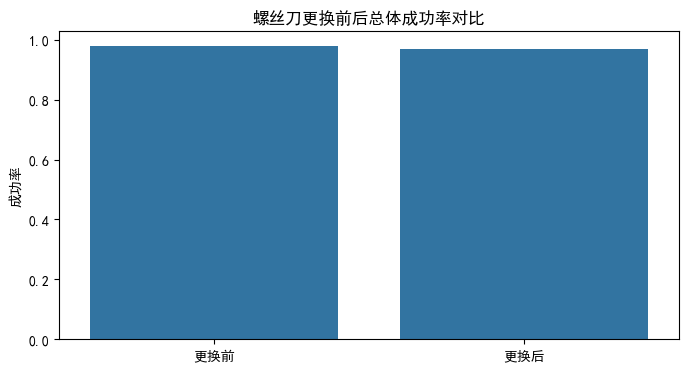


卡方检验结果: p=0.1375
结论: 更换前后成功率无显著差异


In [ ]:
# 1. 总体成功率分析
def analyze_overall_failure(df):
    """分析更换前后的总体成功率变化"""
    before_failure = df[df['change'] == 0]['overall_result'].mean()
    after_failure = df[df['change'] == 1]['overall_result'].mean()
    
    print(f"更换前成功率: {before_failure:.4f}")
    print(f"更换后成功率: {after_failure:.4f}")
    print(f"成功率变化: {after_failure - before_failure:.4f}")
    
    # 绘制成功率对比图
    plt.figure(figsize=(8, 4))
    sns.barplot(x=['更换前', '更换后'], y=[before_failure, after_failure])
    plt.ylabel('成功率')
    plt.title('螺丝刀更换前后总体成功率对比')
    plt.savefig('../datas/imgs/change/overall_failure_rate.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 统计检验
    contingency_table = pd.crosstab(df['change'], df['overall_result'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n卡方检验结果: p={p:.4f}")
    if p < 0.05:
        print("结论: 更换前后成功率有显著差异")
    else:
        print("结论: 更换前后成功率无显著差异")

print("1. 总体成功率分析")
analyze_overall_failure(df_process)

2. 按工站分析成功率


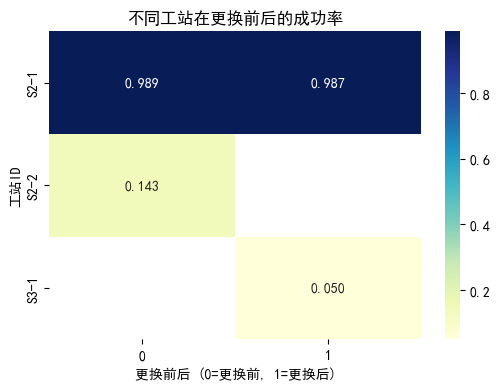

In [84]:
# 2. 按工站分析成功率
def analyze_station_failure(df):
    """分析不同工站的成功率变化"""
    # 按工站和更换前后分组计算成功率
    station_stats = df.groupby(['s2s3installptid', 'change'])['overall_result'].agg(
        total='count',
        failures='sum'
    ).reset_index()
    
    station_stats['failure_rate'] = station_stats['failures'] / station_stats['total']
    
    # 绘制工站成功率热力图
    pivot_table = station_stats.pivot(index='s2s3installptid', columns='change', values='failure_rate')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('不同工站在更换前后的成功率')
    plt.ylabel('工站ID')
    plt.xlabel('更换前后 (0=更换前, 1=更换后)')
    plt.savefig('../datas/imgs/change/station_failure_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 对每个工站进行卡方检验
    significant_stations = []
    for station in df['s2s3installptid'].unique():
        before_data = df[(df['s2s3installptid'] == station) & (df['change'] == 0)]['overall_result']
        after_data = df[(df['s2s3installptid'] == station) & (df['change'] == 1)]['overall_result']
        
        contingency_table = pd.crosstab(before_data.index, before_data.values)
        if len(before_data) > 5 and len(after_data) > 5:  # 确保有足够的数据
            _, p, _, _ = chi2_contingency(contingency_table)
            if p < 0.05:
                significant_stations.append(station)
                print(f"工站 {station} 更换前后成功率有显著差异 (p={p:.4f})")

print("2. 按工站分析成功率")
analyze_station_failure(df_process)


In [92]:
numeric_cols = [
    'maxpressspkdata', 'maxpresschgdata', 'bracketmaxpress', 'spk screw 4_half finaltorque', 'spk screw 4_half finalangle', 'spk screw 4 prevailingtorquemax', 
    'spk screw 4 prevailingtorquemaxangle', 'spk screw 4_half realangle', 'spk screw 4_half torqueat630', 'spk screw 4_half prev torque retest logic', 
    'kc screw 2_full finaltorque', 'kc screw 2_full finalangle', 'kc screw 2_full prevailingtorquemax', 'kc screw 2_full prevailingtorquemaxangle', 
    'kc screw 2_full realangle', 'kc screw 2_full torqueat630', 'kc screw 2_full prev torque retest logic', 'kc screw 1_full finaltorque', 'kc screw 1_full finalangle', 
    'kc screw 1_full prevailingtorquemax', 'kc screw 1_full prevailingtorquemaxangle', 'kc screw 1_full realangle', 'kc screw 1_full torqueat630', 
    'kc screw 1_full prev torque retest logic', 'spk screw 4_full finaltorque', 'spk screw 4_full finalangle', 'spk screw 4_full totalangle', 'spk screw 4_full prev torque retest logic'
]

4. 数值型变量分析

数值型变量分析结果:
                                 variable  before_mean  after_mean  difference  p_value  significant
                          maxpressspkdata    19.688825   19.555811   -0.133014      NaN        False
                          maxpresschgdata     7.792486    7.874199    0.081712      NaN        False
                          bracketmaxpress    11.753263   11.597320   -0.155944      NaN        False
             spk screw 4_half finaltorque     0.171872    0.171870   -0.000003      NaN        False
              spk screw 4_half finalangle   837.889412  918.783888   80.894476      NaN        False
          spk screw 4 prevailingtorquemax     0.098870    0.075844   -0.023026      NaN        False
     spk screw 4 prevailingtorquemaxangle   523.241657  459.159807  -64.081850      NaN        False
               spk screw 4_half realangle  1110.907506 1191.759110   80.851604      NaN        False
             spk screw 4_half torqueat630     0.086856    0.063855  

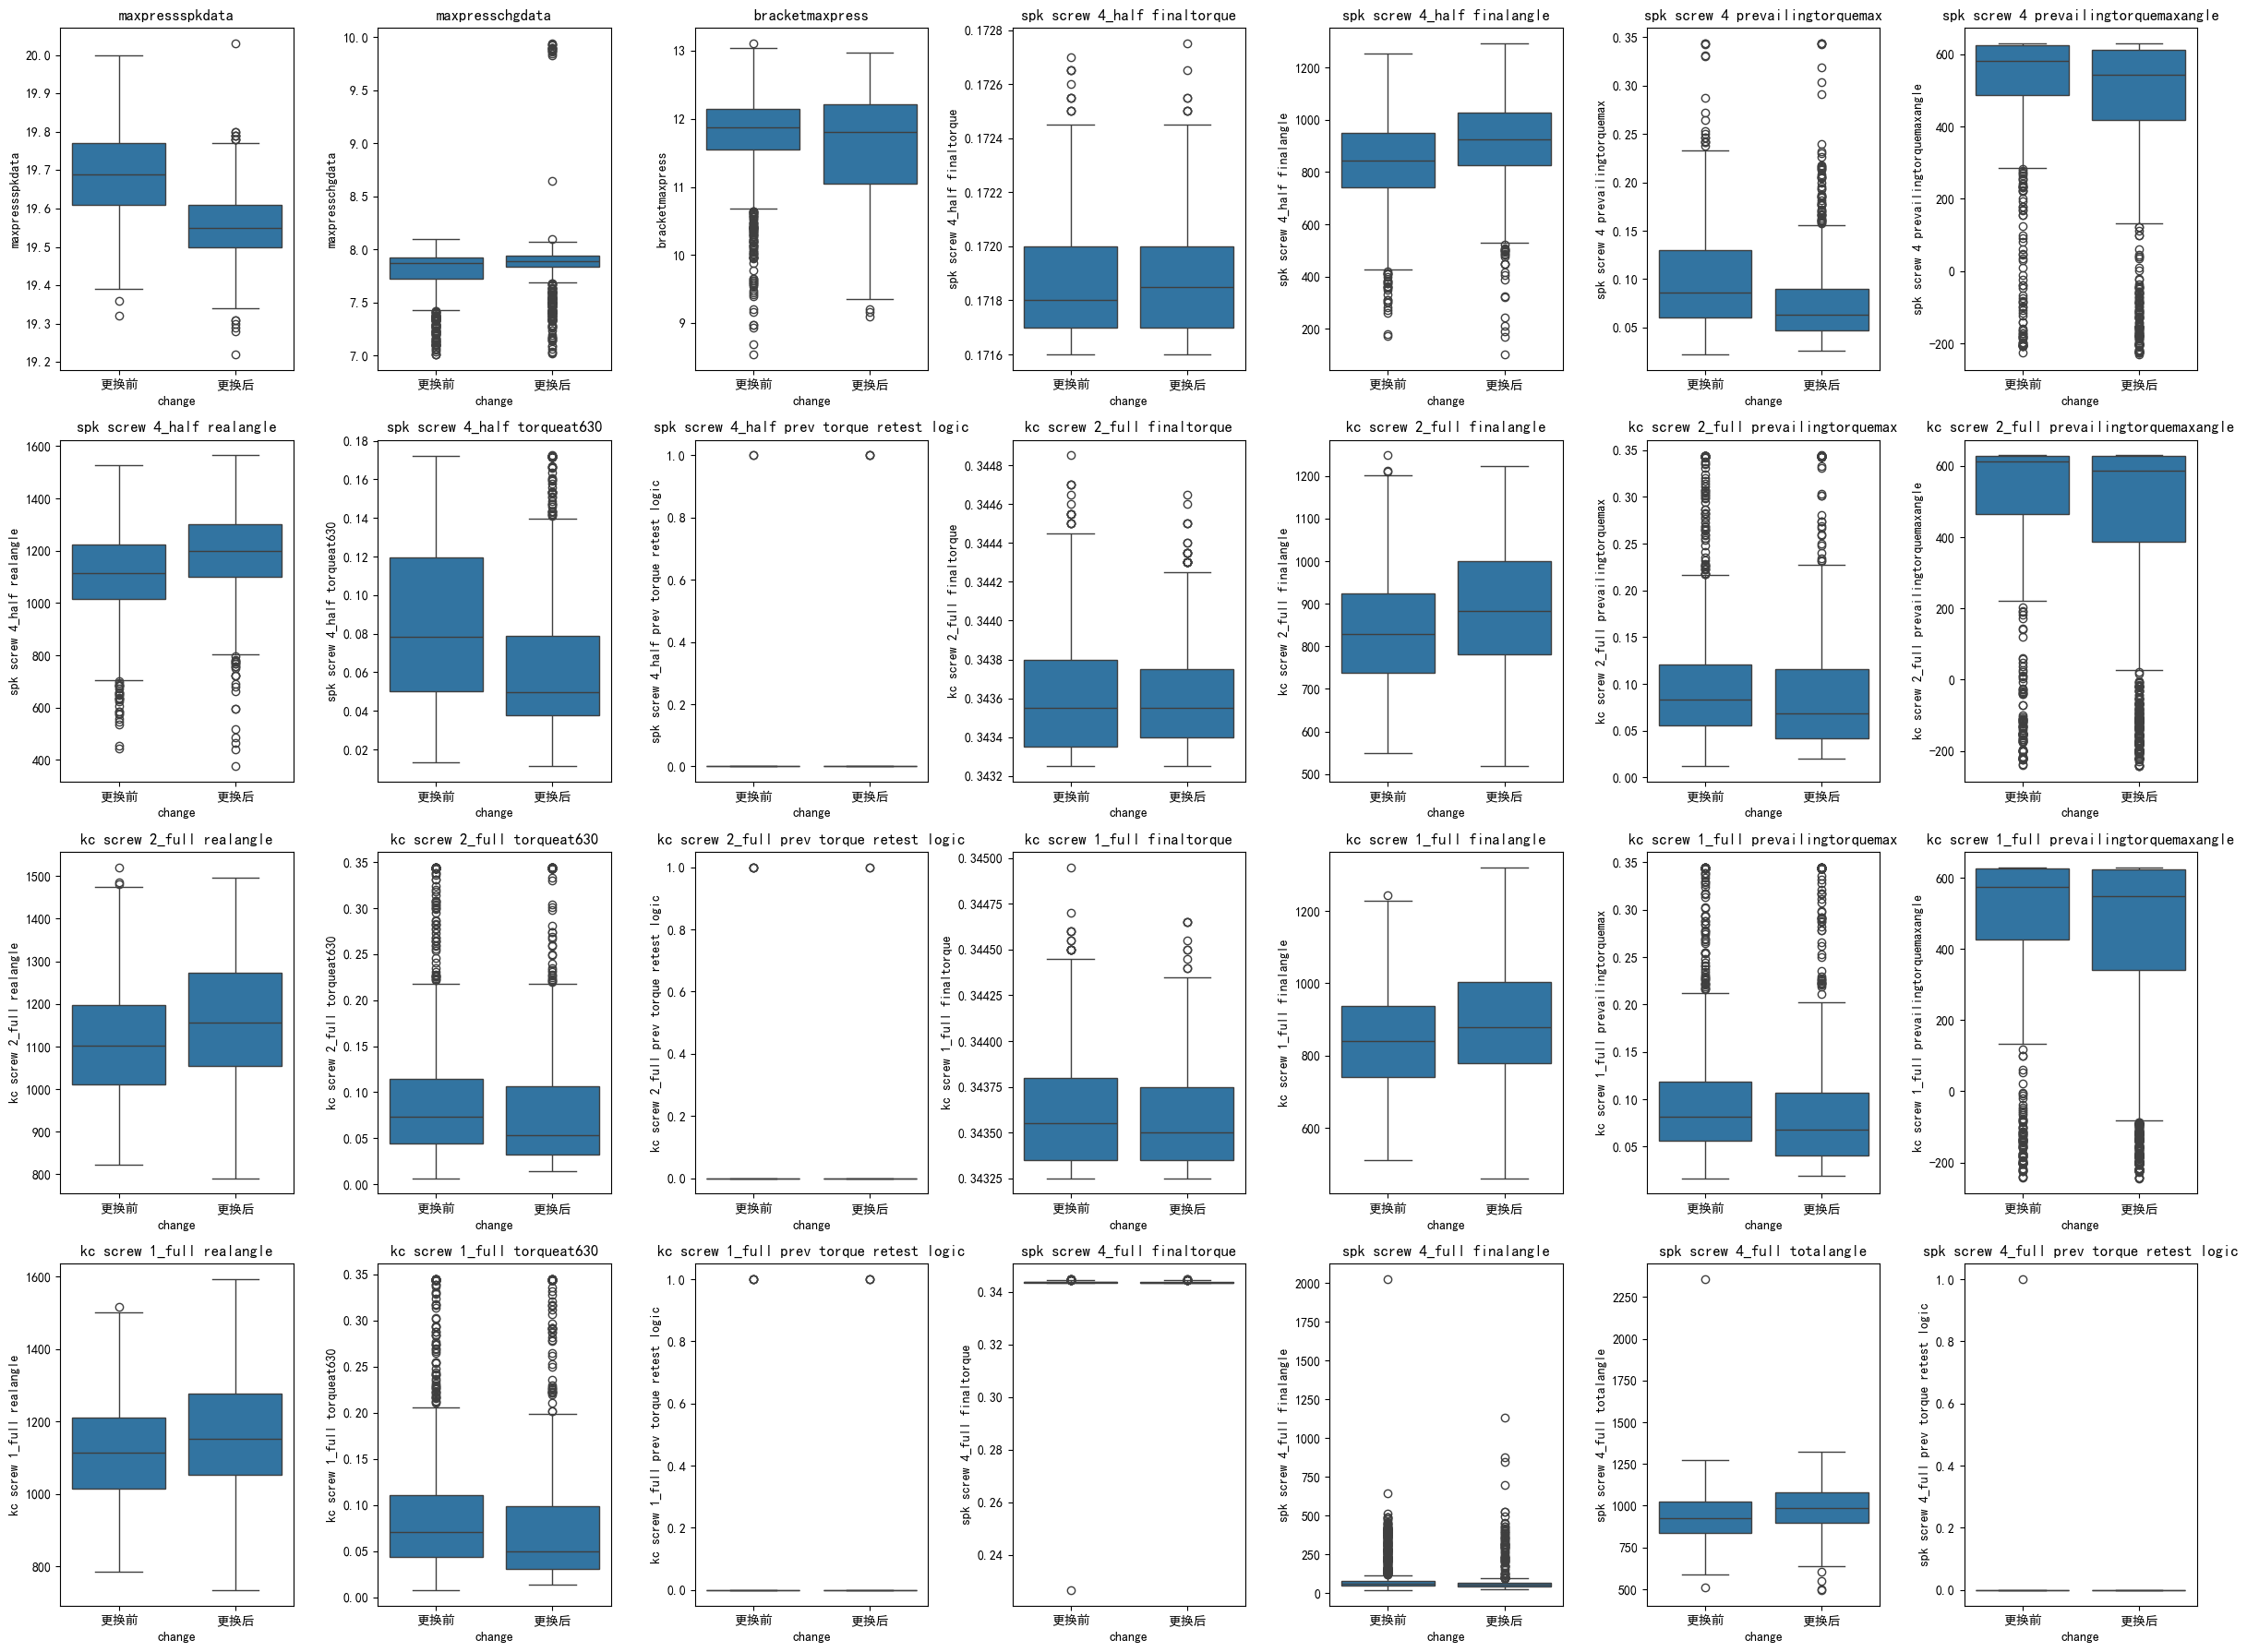

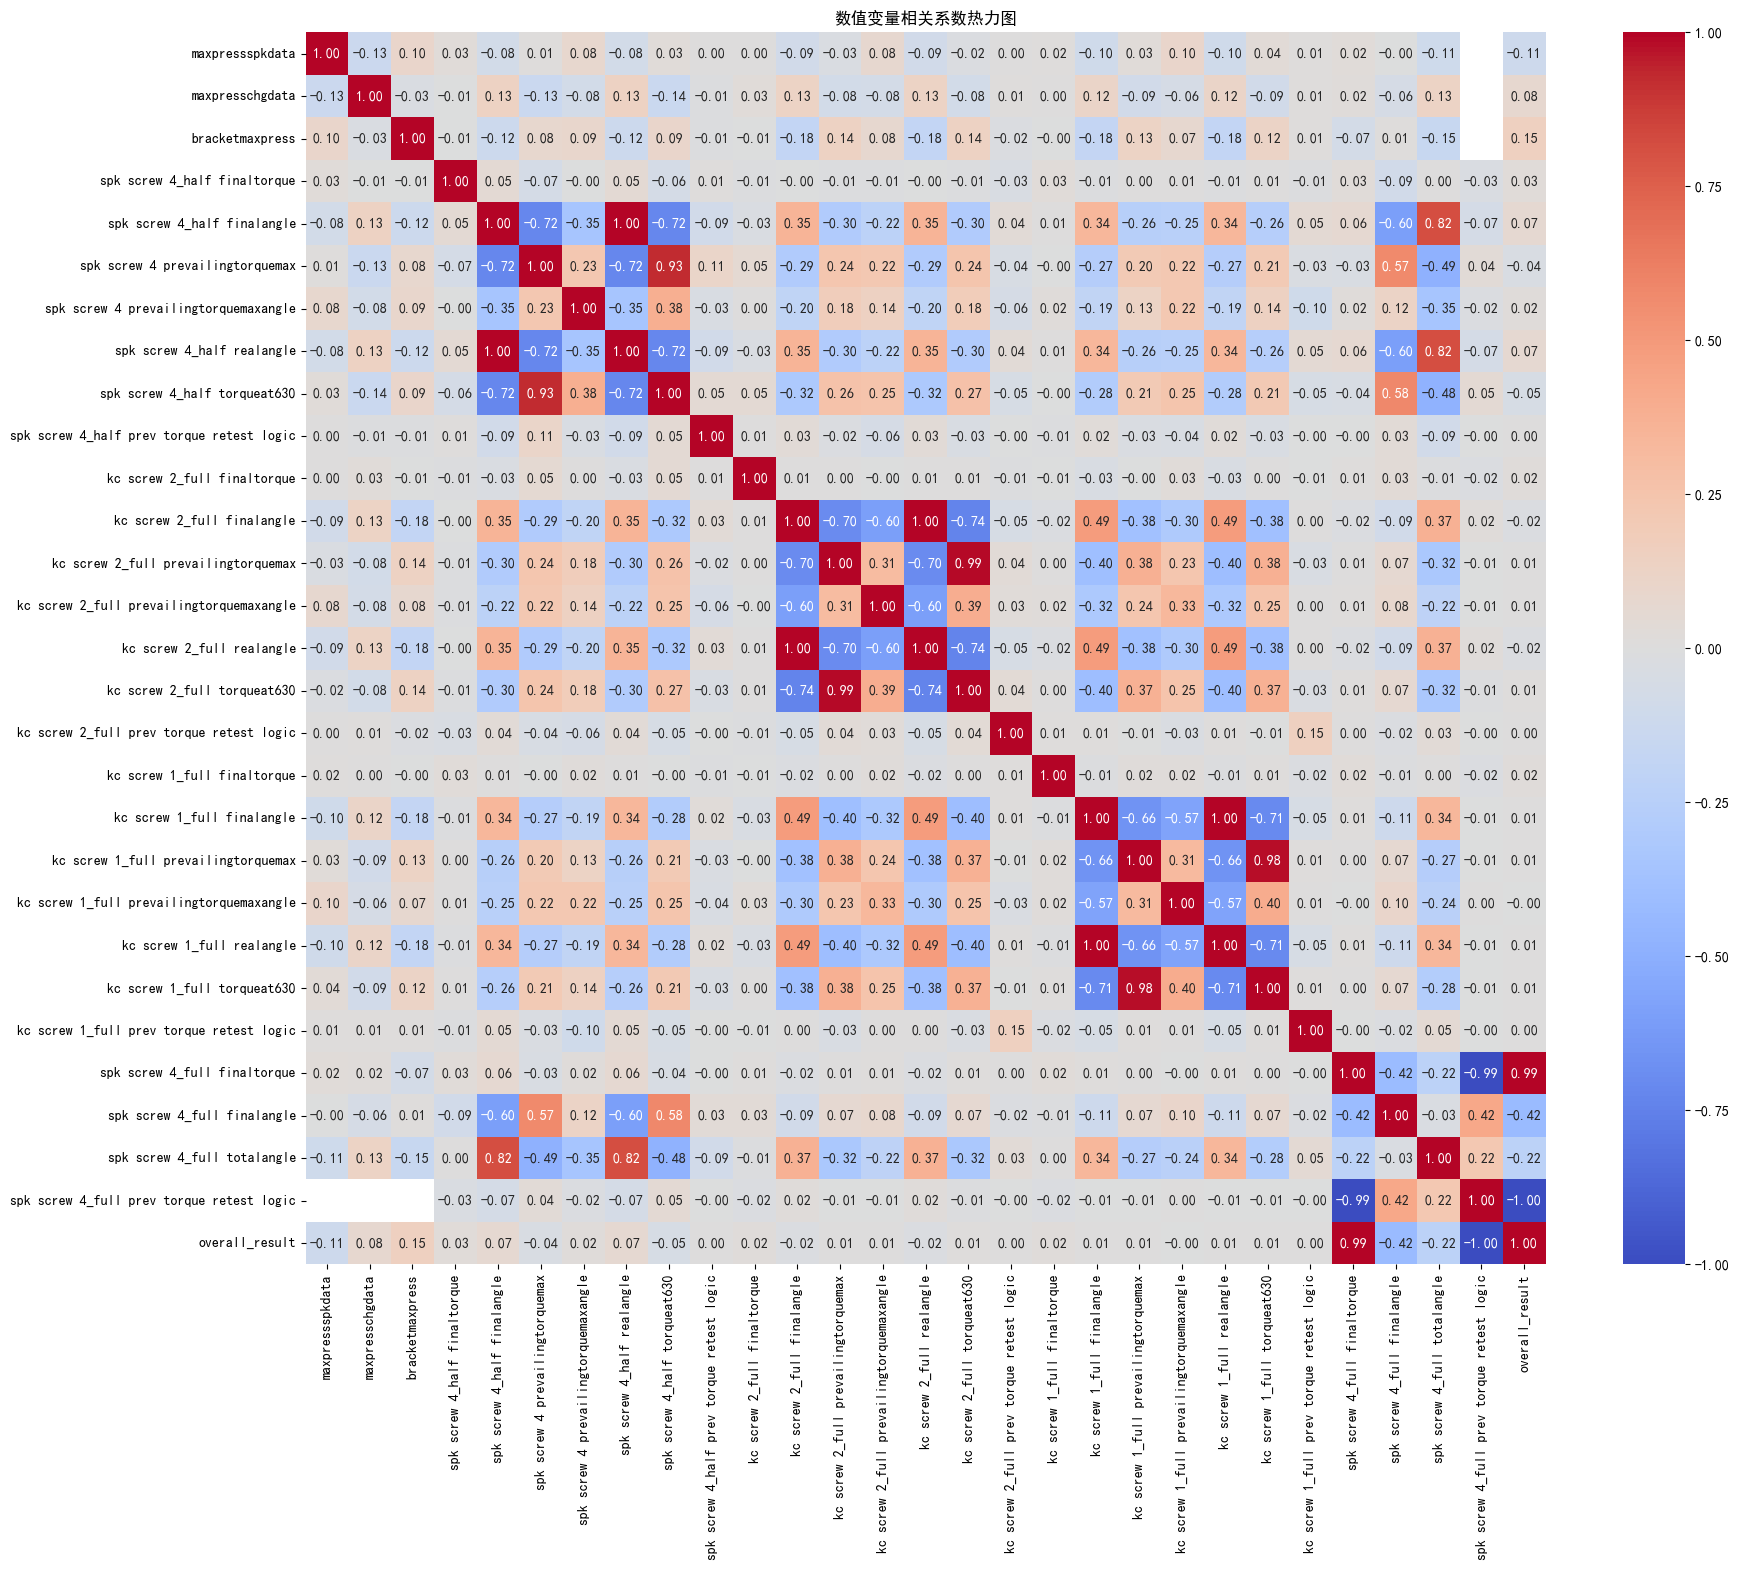

In [95]:
# 4. 数值型变量分析
def analyze_numeric_variables(df):
    """分析数值型变量在更换前后的变化"""
    # 计算每个数值变量的平均值差异
    results = []
    for col in numeric_cols:
        before_mean = df[df['change'] == 0][col].mean()
        after_mean = df[df['change'] == 1][col].mean()
        diff = after_mean - before_mean
        
        # 进行Mann-Whitney U检验(非参数检验，不假设正态分布)
        _, p = mannwhitneyu(df[df['change'] == 0][col], df[df['change'] == 1][col])
        
        results.append({
            'variable': col,
            'before_mean': before_mean,
            'after_mean': after_mean,
            'difference': diff,
            'p_value': p
        })
    
    results_df = pd.DataFrame(results)
    results_df['significant'] = results_df['p_value'] < 0.05
    
    print("\n数值型变量分析结果:")
    print(results_df.to_string(index=False))
    
    # 绘制数值变量变化箱线图
    fig, axs = plt.subplots(4, 7, figsize=(24, 18))
    for idx, col in enumerate(numeric_cols):
        sns.boxplot(x='change', y=col, data=df, ax=axs[idx // 7, idx % 7])
        axs[idx // 7, idx % 7].set_xticks([0, 1], ['更换前', '更换后'])
        axs[idx // 7, idx % 7].set_title(f'{col}')
    plt.tight_layout()
    plt.savefig(f'../datas/imgs/change/boxplot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 绘制热力图显示相关系数
    corr_matrix = df[numeric_cols + ['overall_result']].corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('数值变量相关系数热力图')
    plt.savefig('../datas/imgs/change/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return results_df

print("4. 数值型变量分析")
numeric_results = analyze_numeric_variables(df_process)

5. 成功原因分析


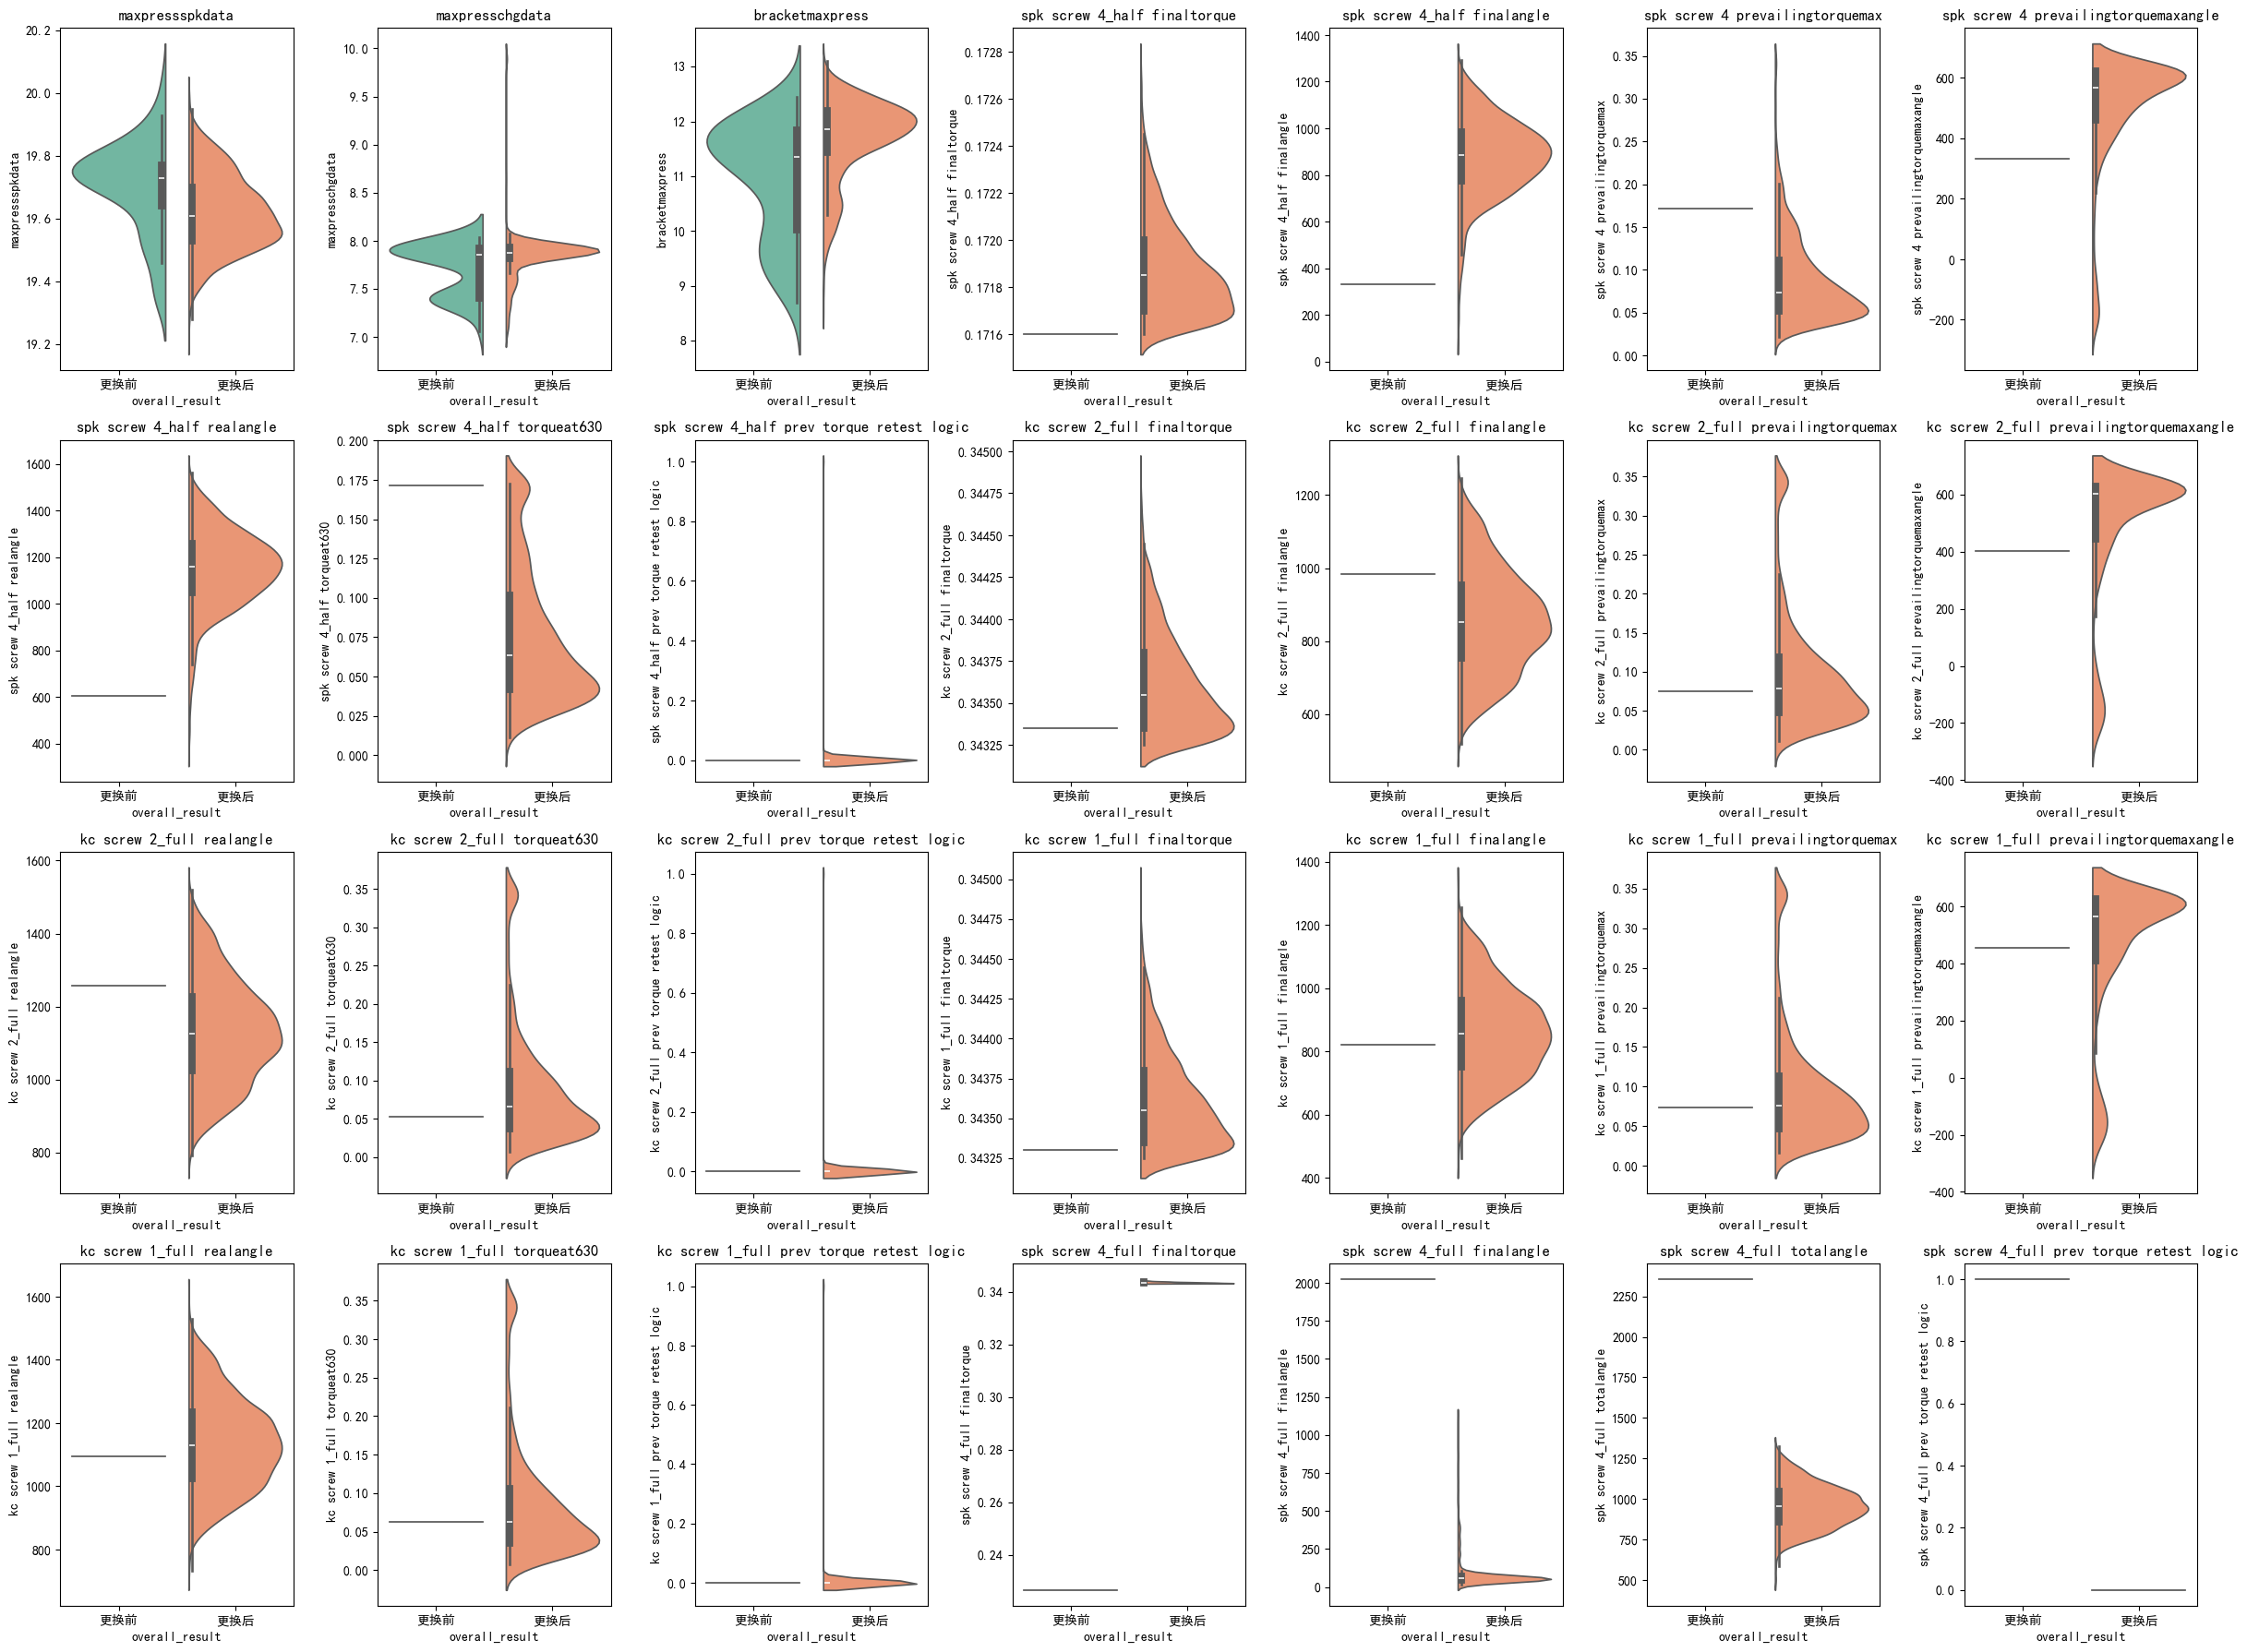

In [96]:
# 5. 成功原因分析
def analyze_failure_reasons(df):
    """分析成功原因及各因素之间的关系"""
    # 分析成功与数值变量的关系
    fig, axs = plt.subplots(4, 7, figsize=(24, 18))
    for idx, col in enumerate(numeric_cols):
        sns.violinplot(x='overall_result', y=col, data=df, split=True, palette='Set2', ax=axs[idx // 7, idx % 7])
        axs[idx // 7, idx % 7].set_xticks([0, 1], ['更换前', '更换后'])
        axs[idx // 7, idx % 7].set_title(f'{col}')
    plt.savefig(f'../datas/imgs/change/vs_failure.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

print("5. 成功原因分析")
analyze_failure_reasons(df_process)

6. 特征重要性分析


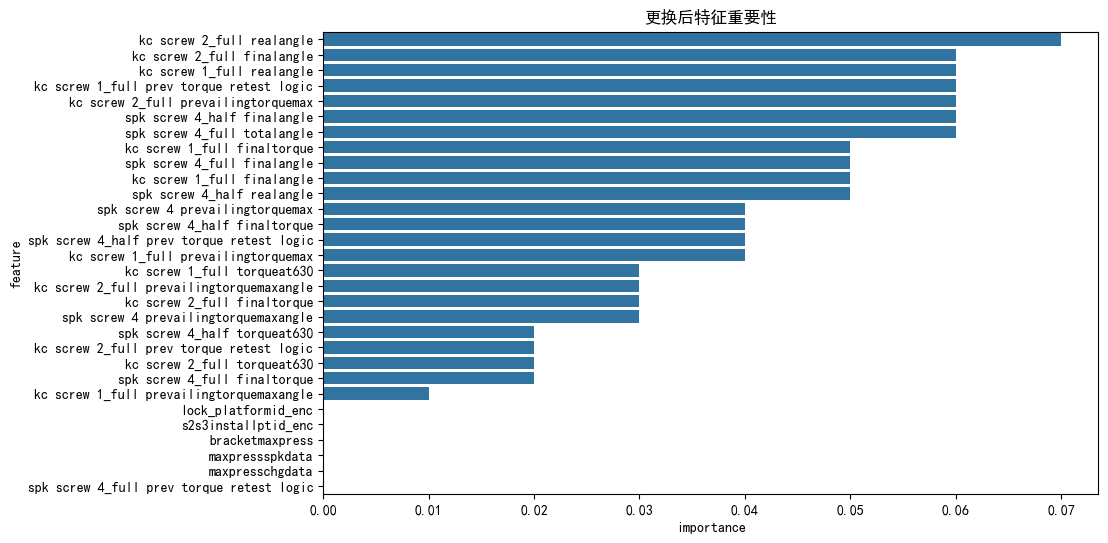


特征重要性:
                                  feature  importance
                kc screw 2_full realangle        0.07
               kc screw 2_full finalangle        0.06
                kc screw 1_full realangle        0.06
 kc screw 1_full prev torque retest logic        0.06
      kc screw 2_full prevailingtorquemax        0.06
              spk screw 4_half finalangle        0.06
              spk screw 4_full totalangle        0.06
              kc screw 1_full finaltorque        0.05
              spk screw 4_full finalangle        0.05
               kc screw 1_full finalangle        0.05
               spk screw 4_half realangle        0.05
          spk screw 4 prevailingtorquemax        0.04
             spk screw 4_half finaltorque        0.04
spk screw 4_half prev torque retest logic        0.04
      kc screw 1_full prevailingtorquemax        0.04
              kc screw 1_full torqueat630        0.03
 kc screw 2_full prevailingtorquemaxangle        0.03
              kc scr

In [104]:
# 6. 特征重要性分析(如果有足够的数据)
def feature_importance_analysis(df, change=1):
    """分析各特征对成功的影响程度"""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    # 准备数据
    features = [
        's2s3installptid_enc', 'lock_platformid_enc',
    ] + numeric_cols
    
    df = df[df['change'] == change]
    X = df[features]
    y = df['overall_result']
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 训练随机森林模型
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 获取特征重要性
    importance = model.feature_importances_
    feature_names = X.columns

    # 组合成DataFrame并按重要性降序排序
    df = pd.DataFrame({'feature': feature_names, 'importance': importance})
    df_sorted = df.sort_values(by='importance', ascending=False)  # 关键排序步骤

    
    # 绘制特征重要性图
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=df_sorted)
    if change == 0:
        plt.title('更换前特征重要性')
        plt.savefig('../datas/imgs/change/feature_importance_before.png', dpi=300, bbox_inches='tight')
    elif change == 1:
        plt.title('更换后特征重要性')
        plt.savefig('../datas/imgs/change/feature_importance_after.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n特征重要性:")
    print(df_sorted.to_string(index=False))

print("6. 特征重要性分析")
feature_importance_analysis(df_process, 1)